In [1]:
import pandas as pd
import numpy as np
import spacy
import glob
from sklearn.utils import shuffle
from scipy.optimize import minimize

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
sample_complete = pd.read_csv('data\\labeled300.csv', index_col=0)
sample_complete['transcript'] = sample_complete['transcript'] + ' '
sample = sample_complete.drop(columns=['id'])
sample = sample.drop(columns=sample_complete.loc[:, '0':'24'].columns)
sample = sample.groupby(['medium', 'dominant topic']).sum()
#sample = sample.loc[['NachDenkSeiten', 'Spiegel', 'ZDFheute', 'BILD', 'Junge Freiheit']]


TOPIC = 'Parteienpolitik'
MEDIA = ['NachDenkSeiten', 'Spiegel', 'ZDFheute', 'BILD', 'Junge Freiheit']
sample_grouped = sample
sample = pd.DataFrame(index=MEDIA, columns=['transcript'])
for medium in MEDIA:
    sample.loc[medium] = sample_grouped.loc[medium].loc[TOPIC]['transcript']


cv = CountVectorizer(ngram_range=(1,1))
N_matrix = cv.fit_transform(sample['transcript'].values)
N_df = pd.DataFrame(data=N_matrix.toarray().transpose(),
                    columns=sample.index,
                    index=cv.get_feature_names_out())

In [80]:
from scipy.stats import poisson
from sklearn.decomposition import TruncatedSVD

def convert_x_to_uvw(x):
    u = np.reshape(x[:u_guess.size], u_shape)
    v = np.reshape(x[u_guess.size:u_guess.size+v_guess.size], v_shape)
    w = np.diag(x[u_guess.size+v_guess.size:])
    return u, v, w

def convert_uvw_to_x(u, v, w):
    u = u[:,:r].flatten()
    w = [w[i, i] for i in range(r)]
    v = v[:r, :].flatten()
    return np.append(np.append(u, v), w)

def objective(x):
    global N_df
    #u, v, w = convert_x_to_uvw(x)
    #mu = u.dot(w).dot(v)
    x = x.reshape(20, r)
    svd.fit_transform(N_df)
    mu = svd.inverse_transform(x)
    P_matrix = poisson.pmf(k=N_df.values, mu=mu)
    P_matrix[P_matrix == 0] = 1e-12
    loss_function = -1.0* np.log(np.product(P_matrix, axis=None))
    return loss_function

def constraint_1(x):
    u, v, w = convert_x_to_uvw(x)
    v = np.zeros(v.shape)
    w = np.zeros(w.shape)
    u_unitary = u.dot(u.transpose())# - np.diag(np.ones(u_shape[0]))
    if np.allclose(u_unitary, np.diag(np.ones(u_shape[0]))):
        return 0
    else:
        return 1
    #return np.sum(u, axis=0) #convert_uvw_to_x(u, v, w) 

def constraint_2(x):
    u, v, w = convert_x_to_uvw(x)
    u = np.zeros(u.shape)
    w = np.zeros(w.shape)
    v_unitary = v.dot(v.transpose())# - np.diag(np.ones(v_shape[0]))
    if np.allclose(v_unitary, np.diag(np.ones(v_shape[0]))):
        return 0
    else:
        return 1
    #return np.sum(v, axis=0) #convert_uvw_to_x(u, v, w)


r = 2
N_df = N_df.iloc[:20]

svd = TruncatedSVD(n_components=r)

u_shape = (len(N_df.index), r)
v_shape = (r, len(N_df.columns))
w_shape = (r)

u_guess = np.ones(u_shape[0]*u_shape[1])
v_guess = np.ones(v_shape[0]*v_shape[1])
w_guess = np.ones(w_shape)

#x0 = np.append(np.append(u_guess, v_guess), w_guess)
x0 = np.ones(20*r)
#bounds = [(0, None) if i>=u_shape[0]*u_shape[1]+v_shape[0]+v_shape[1] else (None, None) for i in range(x0.size)]
bounds = [(0, None) for i in x0]
con1 = {'type':'eq', 'fun':constraint_1}
con2 = {'type':'eq', 'fun':constraint_2}
cons = [con1, con2]

sol = minimize(fun=objective, x0=x0, bounds=bounds)#, constraints=cons)
#u, v, w = convert_x_to_uvw(sol.x)
#lambda_matrix = u.dot(w.dot(v))


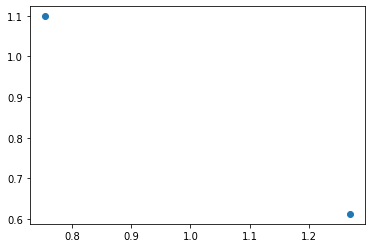

array([[0.75537578, 1.26909284],
       [1.09870076, 0.61254136],
       [1.65399599, 0.71754359],
       [0.75537763, 1.26909209],
       [1.06304938, 0.64807357],
       [0.7553794 , 1.2690878 ],
       [0.67171897, 1.06438403],
       [0.67171626, 1.06438442],
       [0.59858439, 0.8381399 ],
       [1.36191934, 0.57902619],
       [1.09870041, 0.61254206],
       [0.67171608, 1.06438788],
       [4.55263422, 1.59767132],
       [1.06304868, 0.64807379],
       [1.46242139, 1.57145703],
       [1.09870198, 0.6125409 ],
       [0.67171966, 1.06438584],
       [0.67171769, 1.06438772],
       [0.75538266, 1.26909138],
       [0.67171775, 1.06438387]])

In [94]:
import matplotlib.pyplot as plt
plt.scatter(sol.x.reshape(20, r)[0], sol.x.reshape(20, r)[1])
plt.show()
sol.x.reshape(20, r)

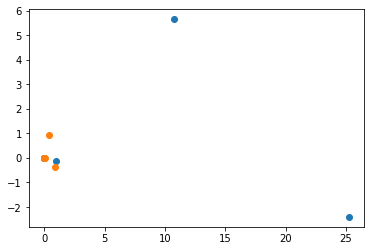

In [110]:
temp = svd.fit_transform(N_df.values.transpose())
plt.scatter(temp.transpose()[0], temp.transpose()[1])

svd.fit_transform(N_df)
plt.scatter(svd.components_[0], svd.components_[1])